In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MatplotlibPolygon
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import math
from scipy.spatial import distance_matrix

In [ ]:
drone_area=[100,76]
threshold= 0

In [ ]:
y=[23.15898023692201,23.157444756331646,23.156919296250468,23.156273855979492,23.155543890020983,23.155171951102513,23.15498048198831,
   23.15484485786686,23.154581587099432,23.154270448278822,23.154102911691528,23.153951330789162,23.15369603625015,23.154382139220647,
   23.155610733435037,23.156679760792034,23.157070859118722,23.15726272078081,23.15755789202827,23.158731191305698,23.15897470496221,
   23.159011600932164]
x=[72.66370466003174,72.66278507603174,72.66247708725945,72.66214280260935,72.66170823256424,72.66246210360988,72.66287859254284,
   72.66339052685626,72.66447513346304,72.6657246002619,72.66634065680856,72.6668178837109,72.66744261711034,72.66772895325174,
   72.66813676533191,72.66847516258994,72.66759599859284,72.66718667521842,72.66642421011178,72.66415286668887,72.66366328383091,
   72.6636873616764]

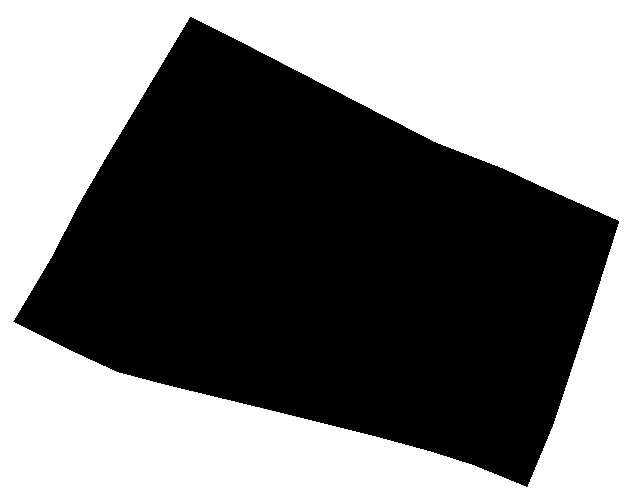

In [ ]:
min_y=min(y)
max_y=max(y)
min_x=min(x)
max_x=max(x)

dis_x=[]
dis_y=[]
for i in range(len(x)):
    dis_x.append((x[i]-min_x)*111000)
    dis_y.append((y[i]-min_y)*111000)
dis_x.append(dis_x[0])
dis_y.append(dis_y[0])

cordinates=[]
for i in range(len(x)):
    k=(dis_x[i],dis_y[i])
    cordinates.append(k)
cordinates

polygon = Polygon(cordinates)

x_len=(max_x-min_x)*111000
y_len=(max_y-min_y)*111000

polygon_coordinates = cordinates

x_points = np.linspace(0, x_len, 10000)
y_points = np.linspace(0, y_len, 10000)
X, Y = np.meshgrid(x_points, y_points)
points = np.column_stack((X.ravel(), Y.ravel()))

polygon = MatplotlibPolygon(polygon_coordinates, edgecolor='blue', facecolor='black')

fig, ax = plt.subplots()

ax.add_patch(polygon)

interior = polygon.get_path().contains_points(points)
points_outside = points[~interior]
plt.plot(points_outside[:, 0], points_outside[:, 1], 'wo', markersize=1)
ax.set_axis_off()
plt.gca().set_aspect('equal', adjustable='box')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("polygon_plot.png")

image=cv2.imread('/content/polygon_plot.png',cv2.IMREAD_GRAYSCALE)
inverted=cv2.bitwise_not(image)
cv2.imwrite('inverted_polygon.png',inverted)

image_path = '/content/inverted_polygon.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_h = cv2.imread(image_path)

In [ ]:
threshold_binary_matrix_max = 128
binary_matrix = (image > threshold_binary_matrix_max).astype(np.uint8)

total_area=[x_len,y_len]

fil_len1=(image.shape[1]/total_area[0])*drone_area[0]
fil_len0=(image.shape[0]/total_area[1])*drone_area[1]

fil_len0=math.ceil(fil_len0)
fil_len1=math.ceil(fil_len1)

filter_matrix = np.ones((fil_len0,fil_len1), dtype=np.uint8)

matrix = binary_matrix

row_add=((int(binary_matrix.shape[0]/filter_matrix.shape[0])+1)*filter_matrix.shape[0])-binary_matrix.shape[0]
col_add=((int(binary_matrix.shape[1]/filter_matrix.shape[1])+1)*filter_matrix.shape[1])-binary_matrix.shape[1]

rows_of_zeros = np.zeros((row_add, matrix.shape[1]), dtype=matrix.dtype)

matrix_with_zeros_rows = np.vstack((matrix, rows_of_zeros))

column_of_zeros = np.zeros((matrix_with_zeros_rows.shape[0], col_add), dtype=matrix_with_zeros_rows.dtype)

final_binary = np.hstack((matrix_with_zeros_rows, column_of_zeros))

result_matrix = np.zeros((int(final_binary.shape[0]/filter_matrix.shape[0]),int(final_binary.shape[1]/filter_matrix.shape[1])), dtype=np.uint8)

for i in range(result_matrix.shape[0]):
    for j in range(result_matrix.shape[1]):
        block = final_binary[i*filter_matrix.shape[0]:i*filter_matrix.shape[0]+filter_matrix.shape[0], j*filter_matrix.shape[1]:j*filter_matrix.shape[1]+filter_matrix.shape[1]]
        result_matrix[i, j] = np.sum(block * filter_matrix)


matrix = np.copy(image_h)

rows_of_zeros=[]
for i in range(row_add):
  temp=[]
  for j in range(matrix.shape[1]):
    temp.append([0,0,0])
  rows_of_zeros.append(temp)
rows_of_zeros=np.array(rows_of_zeros)

matrix_with_zeros_rows = np.vstack((matrix, rows_of_zeros))

column_of_zeros=[]
for i in range(matrix.shape[0]+row_add):
  temp=[]
  for j in range(col_add):
    temp.append([0,0,0])
  column_of_zeros.append(temp)
column_of_zeros=np.array(column_of_zeros)

in_fin = np.hstack((matrix_with_zeros_rows, column_of_zeros))

for y in range(result_matrix.shape[0]):
    for x in range(result_matrix.shape[1]):
        if result_matrix[y, x] > threshold:
            for i in range(filter_matrix.shape[0]):
              for j in range(filter_matrix.shape[1]):
                in_fin[y*filter_matrix.shape[0]+i,x*filter_matrix.shape[1]+j]=[0,255,0]
        else:
            for i in range(filter_matrix.shape[0]):
              for j in range(filter_matrix.shape[1]):
                in_fin[y*filter_matrix.shape[0]+i,x*filter_matrix.shape[1]+j]=[0,0,255]

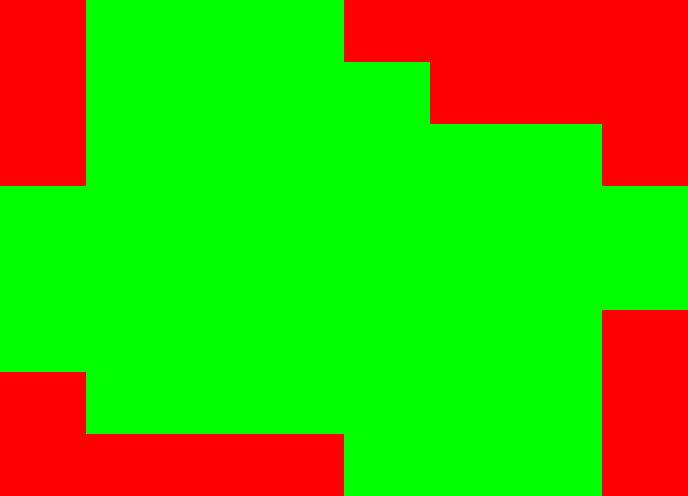

In [ ]:
temp=np.copy(in_fin)
temp2=np.copy(in_fin)

cv2_imshow(in_fin)


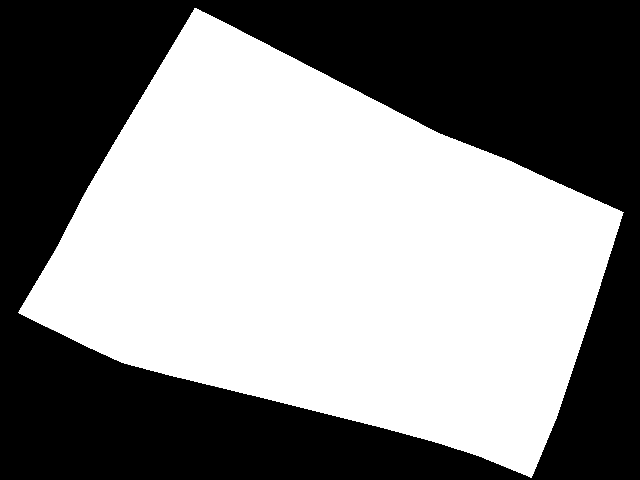

In [ ]:
cv2.imwrite('drone_green_red.png',in_fin)
cv2_imshow(image)

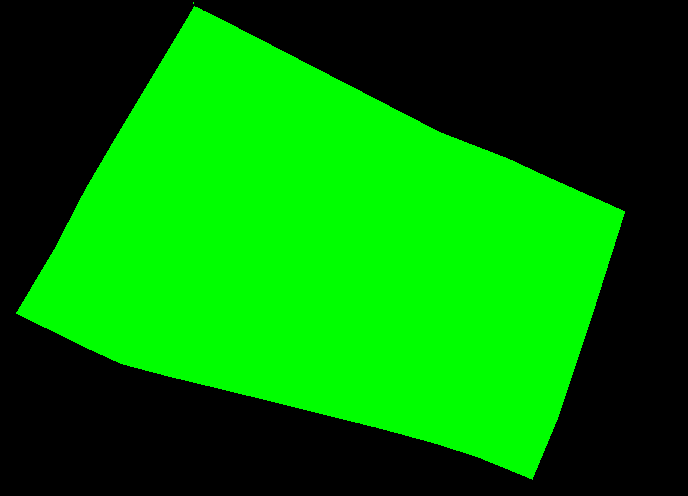

In [ ]:
for i in range(temp.shape[0]):
  for j in range(temp.shape[1]):
    if ( i>=480 or j>=640 or image[i,j]==0):
      temp[i,j]=[0,0,0]
cv2_imshow(temp)

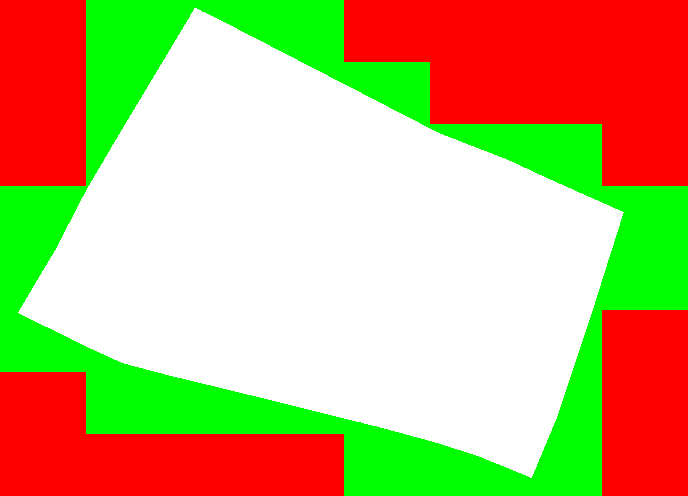

In [ ]:
for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    if image[i,j]==255:
      temp2[i,j]=[255,255,255]
cv2_imshow(temp2)

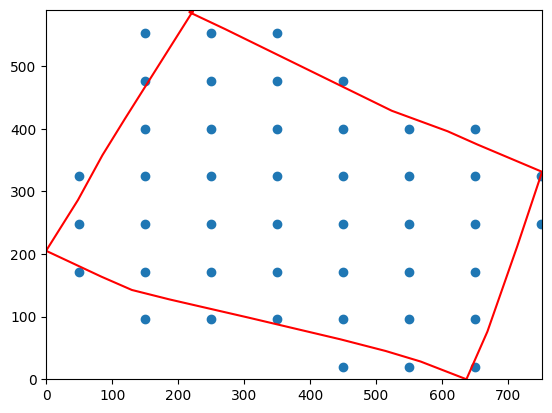

In [ ]:
drone_centroids=[]
for i in range(result_matrix.shape[0]):
  for j in range(result_matrix.shape[1]):
    if(result_matrix[i,j])>threshold:
      temp=[]
      ty=(y_len-(i*drone_area[1])+y_len-((i+1)*drone_area[1]))/2
      tx=((j*drone_area[0])+((j+1)*drone_area[0]))/2
      temp.append(tx)
      temp.append(ty)
      drone_centroids.append(temp)
drone_centroids=np.array(drone_centroids)

plt.figure()
plt.plot(dis_x,dis_y,'r')
plt.xlim([0,((max_x-min_x)*111000)])
plt.ylim([0,((max_y-min_y)*111000)])
plt.scatter(drone_centroids[:,0],drone_centroids[:,1])
plt.savefig("Centroids_Plotted.png")

In [ ]:
print('No Of Required UAVs  = ',len(drone_centroids))

No Of Required UAVs  =  45


In [ ]:
uav_no=np.linspace(1,len(drone_centroids),len(drone_centroids),dtype=int)

number=[]
for i in range(len(uav_no)):
  number.append([uav_no[i]])

centroids_with_number=np.hstack((number,drone_centroids))
print(centroids_with_number)

[[  1.        150.        552.0276797]
 [  2.        250.        552.0276797]
 [  3.        350.        552.0276797]
 [  4.        150.        476.0276797]
 [  5.        250.        476.0276797]
 [  6.        350.        476.0276797]
 [  7.        450.        476.0276797]
 [  8.        150.        400.0276797]
 [  9.        250.        400.0276797]
 [ 10.        350.        400.0276797]
 [ 11.        450.        400.0276797]
 [ 12.        550.        400.0276797]
 [ 13.        650.        400.0276797]
 [ 14.         50.        324.0276797]
 [ 15.        150.        324.0276797]
 [ 16.        250.        324.0276797]
 [ 17.        350.        324.0276797]
 [ 18.        450.        324.0276797]
 [ 19.        550.        324.0276797]
 [ 20.        650.        324.0276797]
 [ 21.        750.        324.0276797]
 [ 22.         50.        248.0276797]
 [ 23.        150.        248.0276797]
 [ 24.        250.        248.0276797]
 [ 25.        350.        248.0276797]
 [ 26.        450.       

In [ ]:
distances = distance_matrix(drone_centroids, drone_centroids)
distances[0]

array([  0.        , 100.        , 200.        ,  76.        ,
       125.60254774, 213.95326593, 309.47697814, 152.        ,
       181.94504665, 251.20509549, 336.30938137, 427.90653185,
       522.5935323 , 248.96586111, 228.        , 248.96586111,
       303.2886414 , 376.80764323, 460.41720211, 549.53070888,
       641.85979778, 320.02499902, 304.        , 320.02499902,
       363.8900933 , 427.10186139, 502.41019098, 585.16322509,
       672.61876275, 392.93765409, 380.        , 392.93765409,
       429.41821107, 484.14873748, 551.72456897, 628.01273872,
       456.        , 466.8361597 , 497.93172223, 545.83513995,
       606.57728279, 676.70968665, 610.75690745, 665.60048077,
       730.08492657])

In [ ]:
distance_threshold = math.sqrt(drone_area[0]**2+drone_area[1]**2)+1

n = len(drone_centroids)
neighbor_matrix = np.zeros((n, n), dtype=int)
neighbor_matrix_number = []

for i in range(n):
    temp=[]
    for j in range(n):
        if i != j and np.sqrt((drone_centroids[i][0] - drone_centroids[j][0])**2 + (drone_centroids[i][1] - drone_centroids[j][1])**2) <= distance_threshold:
            neighbor_matrix[i][j] = 1
            temp.append(int(centroids_with_number[j,0]))
    neighbor_matrix_number.append(temp)
print("Neighbor Matrix:")
print(neighbor_matrix[0])
print(neighbor_matrix_number)

Neighbor Matrix:
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[[2, 4, 5], [1, 3, 4, 5, 6], [2, 5, 6, 7], [1, 2, 5, 8, 9], [1, 2, 3, 4, 6, 8, 9, 10], [2, 3, 5, 7, 9, 10, 11], [3, 6, 10, 11, 12], [4, 5, 9, 14, 15, 16], [4, 5, 6, 8, 10, 15, 16, 17], [5, 6, 7, 9, 11, 16, 17, 18], [6, 7, 10, 12, 17, 18, 19], [7, 11, 13, 18, 19, 20], [12, 19, 20, 21], [8, 15, 22, 23], [8, 9, 14, 16, 22, 23, 24], [8, 9, 10, 15, 17, 23, 24, 25], [9, 10, 11, 16, 18, 24, 25, 26], [10, 11, 12, 17, 19, 25, 26, 27], [11, 12, 13, 18, 20, 26, 27, 28], [12, 13, 19, 21, 27, 28, 29], [13, 20, 28, 29], [14, 15, 23, 30, 31], [14, 15, 16, 22, 24, 30, 31, 32], [15, 16, 17, 23, 25, 31, 32, 33], [16, 17, 18, 24, 26, 32, 33, 34], [17, 18, 19, 25, 27, 33, 34, 35], [18, 19, 20, 26, 28, 34, 35, 36], [19, 20, 21, 27, 29, 35, 36], [20, 21, 28, 36], [22, 23, 31, 37], [22, 23, 24, 30, 32, 37, 38], [23, 24, 25, 31, 33, 37, 38, 39], [24, 25, 26, 32, 34, 38, 39, 40], [25, 26, 27, 33, 35, 3

In [ ]:
distance_threshold = math.sqrt(drone_area[0]**2+drone_area[1]**2)+1

n = len(drone_centroids)
distance_matrix = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        if i != j:
            distance = np.sqrt((drone_centroids[i][0] - drone_centroids[j][0])**2 + (drone_centroids[i][1] - drone_centroids[j][1])**2)
            if distance <= distance_threshold:
                distance_matrix[i][j] = distance
            else:
                distance_matrix[i][j] = float('inf')

print("Distance Matrix:")
print(distance_matrix)

Distance Matrix:
[[  0. 100.  inf ...  inf  inf  inf]
 [100.   0. 100. ...  inf  inf  inf]
 [ inf 100.   0. ...  inf  inf  inf]
 ...
 [ inf  inf  inf ...   0. 100.  inf]
 [ inf  inf  inf ... 100.   0. 100.]
 [ inf  inf  inf ...  inf 100.   0.]]


In [ ]:
centroid = np.mean(drone_centroids, axis=0)
print("Centroid:", centroid)

Centroid: [383.33333333 275.04990193]


In [ ]:
centroids_array = np.array(drone_centroids)
distances = np.linalg.norm(centroids_array - centroid, axis=1)

nearest_centroid_index = np.argmin(distances)

nearest_centroid = centroids_with_number[nearest_centroid_index]

print("Nearest Centroid:", nearest_centroid)

Nearest Centroid: [ 25.        350.        248.0276797]


In [ ]:
distance_matrix

array([[  0., 100.,  inf, ...,  inf,  inf,  inf],
       [100.,   0., 100., ...,  inf,  inf,  inf],
       [ inf, 100.,   0., ...,  inf,  inf,  inf],
       ...,
       [ inf,  inf,  inf, ...,   0., 100.,  inf],
       [ inf,  inf,  inf, ..., 100.,   0., 100.],
       [ inf,  inf,  inf, ...,  inf, 100.,   0.]])

In [ ]:
pathloss_d0=10*math.log10((10**(-0.4)*10*10*(0.1071)**2)/(4*math.pi)**2)
pathloss_d0

-25.38840786380481

In [ ]:
n=len(distance_matrix)
pathloss_matrix=np.zeros((n, n), dtype=float)
for i in range(distance_matrix.shape[0]):
  for j in range(distance_matrix.shape[1]):
    if distance_matrix[i][j]==drone_area[0]:
      pathloss_matrix[i][j]=pathloss_d0 + 20*math.log10(drone_area[0])
    elif distance_matrix[i][j]==drone_area[1]:
      pathloss_matrix[i][j]=pathloss_d0 + 20*math.log10(drone_area[1])
    elif distance_matrix[i][j]==math.sqrt(drone_area[0]**2+drone_area[1]**2):
      pathloss_matrix[i][j]=pathloss_d0 + 20*math.log10(math.sqrt(drone_area[0]**2+drone_area[1]**2))
    else:
      pathloss_matrix[i][j]=0

In [ ]:
pathloss_matrix[0]

array([ 0.        , 14.61159214,  0.        , 12.22786398, 16.59156111,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
tau_matrix=np.sqrt(pathloss_matrix)
tau_matrix[0]

array([0.        , 3.82251123, 0.        , 3.49683628, 4.073274  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
n=len(distance_matrix)
uplink_pathloss=np.zeros((n, n), dtype=float)
for i in range(distance_matrix.shape[0]):
  for j in range(distance_matrix.shape[1]):
    if distance_matrix[i][j]==drone_area[0]:
      uplink_pathloss[i][j] = tau_matrix[i][j] * (drone_area[0])**2
    elif distance_matrix[i][j]==drone_area[1]:
      uplink_pathloss[i][j] = tau_matrix[i][j] * (drone_area[1])**2
    elif distance_matrix[i][j]==math.sqrt(drone_area[0]**2+drone_area[1]**2):
      uplink_pathloss[i][j] = tau_matrix[i][j] * (math.sqrt(drone_area[0]**2+drone_area[1]**2))**2
    else:
      uplink_pathloss[i][j]=0

In [ ]:
uplink_pathloss[0]

array([    0.        , 38225.1123428 ,     0.        , 20197.72636376,
       64259.97068808,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ])

In [ ]:
n=len(distance_matrix)
rayleigh_matrix=np.zeros((n, n), dtype=float)
for i in range(distance_matrix.shape[0]):
  for j in range(distance_matrix.shape[1]):
    if distance_matrix[i][j]!=0 and distance_matrix[i][j]!=float('inf'):
      rayleigh_matrix[i][j]=np.random.rand()
    else:
      rayleigh_matrix[i][j]=0

In [ ]:
rayleigh_matrix

array([[0.        , 0.28622918, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50689341, 0.        , 0.77666719, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.73858248, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.15927235,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.67596564, 0.        ,
        0.31171436],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0994854 ,
        0.        ]])

In [ ]:
snr=10**(-0.4)*(np.divide(rayleigh_matrix,uplink_pathloss))/(10**(-20.4)*360*10**3)

<ipython-input-27-ec401b850e6f>:1: RuntimeWarning: invalid value encountered in divide
  snr=10**(-0.4)*(np.divide(rayleigh_matrix,uplink_pathloss))/(10**(-20.4)*360*10**3)


In [ ]:
snr[0]

array([           nan, 2.07999665e+09,            nan, 4.84926194e+09,
       1.90637312e+08,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan])

In [ ]:
one_matrix=np.ones((n, n), dtype=float)
channel_capacity=(360*10**3) * np.log2(one_matrix + snr)

In [ ]:
channel_capacity[0]

array([              nan, 11143416.26133933,               nan,
       11583042.4937702 ,  9902251.90205198,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan])

In [ ]:
drone_graph={}
for i in range(len(channel_capacity)):
  temp={}
  for j in range(len(channel_capacity[i])):
    if np.isnan(channel_capacity[i][j])==False:
      temp[j]=channel_capacity[i][j]
  drone_graph[i]=temp

In [ ]:
drone_graph

{0: {1: 11143416.26133933, 3: 11583042.493770197, 4: 9902251.902051976},
 1: {0: 11440240.45171019,
  2: 11661861.537463222,
  3: 10553503.2818156,
  4: 11548521.633256473,
  5: 9401772.137852432},
 2: {1: 11635748.039733285,
  4: 11410879.992691277,
  5: 10904433.182192527,
  6: 11169271.724087084},
 3: {0: 12011814.350392833,
  1: 11033271.096880568,
  4: 11163330.03929743,
  7: 12118495.962511526,
  8: 11087083.311763002},
 4: {0: 11125475.92567196,
  1: 12084278.298045335,
  2: 10820172.086619753,
  3: 10939849.381860469,
  5: 11737455.42871573,
  7: 11509785.083309064,
  8: 11784436.08592436,
  9: 10806645.106010122},
 5: {1: 11508391.6571136,
  2: 11987282.635616532,
  4: 11743551.576790871,
  6: 10993558.413709456,
  8: 11253480.86559723,
  9: 11625704.40985715,
  10: 10469557.786754},
 6: {2: 11464370.758770583,
  5: 11696766.240044262,
  9: 11472917.727975262,
  10: 12012818.663928652,
  11: 11154539.77780548},
 7: {3: 12086239.042879786,
  4: 11230775.813676883,
  8: 11272529

In [ ]:
active_drone=int(len(drone_centroids)*0.1)
active_drone

4

In [ ]:
# import random
# randomlist = random.sample(range(0,len(drone_centroids)),int(len(drone_centroids)*0.1))
# print(randomlist)

In [ ]:
randomlist=[4, 12, 29, 40]

In [ ]:
def find_all_paths_th(drone_graph, start, end,threshold=float('inf'),path=[]):
    path = path + [start]
    if start == end:
        return [path]
    if start not in drone_graph:
        return []
    paths = []
    for node in drone_graph[start]:
        if node not in path and len(path)<threshold:
            paths += find_all_paths_th(drone_graph, node, end,threshold,path)

    return paths

In [ ]:
intial_battery_energy=87912 ## if drone is 100% charged then initial_battery_energy=(11.1*2200*3.6) joule

In [ ]:
def drone_path(drone_no,trans_data,intial_battery_energy):

  ## path inintialization
  for_one=sorted(find_all_paths_th(drone_graph, drone_no, 24,5),key=len)

  ## capacity of each path
  cap={}
  for i in range(len(for_one)):
    row_wise={}
    for j in range(len(for_one[i])-1):
      row_wise[for_one[i][j]]=drone_graph[for_one[i][j]][for_one[i][j+1]]
    cap[i]=row_wise

  ## sorting capcity in descending order
  sorted_min_cap={}
  for key,value in cap.items():
    sorted_min_cap[key]=min(value.values())
  sorted_min_cap=sorted(sorted_min_cap.items(), key=lambda item: item[1],reverse=True)

  ## choose first path and calculate energy to transmit the data
  remaining_battery_energy = intial_battery_energy - (10**(-0.4) * (trans_data/sorted_min_cap[0][1]))

  ## Battery of drone
  remaining_battery=remaining_battery_energy/intial_battery_energy
  print("Battery Of The Drone is : ",remaining_battery*100,"%")

  ## after the data transmission, energy of drone
  battery_energy=intial_battery_energy*remaining_battery
  print("After The Data Transmission Energy Of Drone: ",battery_energy,"joule")

  ## updating cap dictionary
  for key in cap[sorted_min_cap[0][0]]:
    cap[sorted_min_cap[0][0]][key]*=remaining_battery

  ## updating drone_graph dictionary
  for i in range(len(for_one[sorted_min_cap[0][0]])-1):
    drone_graph[for_one[sorted_min_cap[0][0]][i]][for_one[sorted_min_cap[0][0]][i+1]]=cap[sorted_min_cap[0][0]][for_one[sorted_min_cap[0][0]][i]]

  return for_one[sorted_min_cap[0][0]]

In [ ]:
drone_path(4,6000000000,intial_battery_energy)

Battery Of The Drone is :  99.76628649238596 %
After The Data Transmission Energy Of Drone:  87706.53778118634 joule


[4, 5, 9, 16, 24]

In [ ]:
drone_path(4,700000000000,87706.53778118634)

Battery Of The Drone is :  71.76555887988555 %
After The Data Transmission Energy Of Drone:  62943.08701286635 joule


[4, 5, 8, 15, 24]

In [ ]:
drone_path(4,800000000000,62324.98660774142)

Battery Of The Drone is :  55.602289111740134 %
After The Data Transmission Energy Of Drone:  34654.1192424897 joule


[4, 7, 15, 23, 24]

In [ ]:
drone_path(12,7000000000,intial_battery_energy)

Battery Of The Drone is :  99.72437713634179 %
After The Data Transmission Energy Of Drone:  87669.69442810079 joule


[12, 11, 17, 25, 24]

In [ ]:
drone_path(29,8000000000,intial_battery_energy)

Battery Of The Drone is :  99.68186564427086 %
After The Data Transmission Energy Of Drone:  87632.3217251914 joule


[29, 21, 14, 15, 24]

In [ ]:
drone_path(40,9000000000,intial_battery_energy)

Battery Of The Drone is :  99.64534046386328 %
After The Data Transmission Energy Of Drone:  87600.21170859148 joule


[40, 34, 25, 24]